# Overfitting, Regularization and Information Criteria 

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import statsmodels.api as smf
import arviz as az
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

### Easy

###### 6E1
State the three motivating criteria that define information entropy. Try to express each in your own words.

**Answer:**  
The three motivating criteria that define information criteria are:

1. The measure of uncertainty should be continuous. If it were not, then an arbitrarily small change in any of the probabilities would result in a massive change in uncertainty.  
  
1. The measure of uncertainty should increase as the number of possible events increases. For example, suppose there are two cities that need weather forecasts. In the first city, it rains on half of the days in the year and is sunny on the others. In the second, it rains, shines, and hails, each on 1 out of every 3 days in the year. We'd like our measure of uncertainty to be larger in the second city, where there is one more kind of event to predict.  
  
1. The measure of uncertainty should be additive. What this means is that if we first measure the uncertainty about rain or shine (2 possible events) and then the uncertainty about hot or cold (2 different possible events), the uncertainty over the four combinations of these events - rain/hot, rain/cold, shine/hot, shine/cold - should be the sum of the separate uncertainties.


###### 6E2
Suppose a coin is weighted such that, when it is tossed and lands on a table, it comes up heads 70\% of the time. What is the entropy of this coin?

**Answer:**  
$$
\begin{align}
Entropy &= - E[log(p_i)] \\
&= - \Sigma^n_{i=1} p_i log(p_i) \\
&= - [0.7 * log(0.7) + 0.3 * log(0.3)] \\
&= 0.265295
\end{align}
$$


###### 6E3
Suppose a four-sided die is loaded such that, when tossed onto a table, it shows "1" 20%, "2" 25%, "3" 25%, and "4" 30% of the time. What is the entropy of this die?

**Answer:**  
$$
\begin{align}
Entropy &= - E[log(p_i)] \\
&= - \Sigma^n_{i=1} p_i log(p_i) \\
&= - [0.2 * log(0.2) + 0.25 * log(0.25) + 0.25 * log(0.25) + 0.3 * log(0.3)] \\
&= 0.59769
\end{align}
$$

###### 6E4
Suppose another four-sided die is loaded such that it never shows "4". The other three sides show equally often. What is the entropy of this die?

**Answer:**  
$$
\begin{align}
Entropy &= - E[log(p_i)] \\
&= - \Sigma^n_{i=1} p_i log(p_i) \\
&= - [1/3 * log(1/3) + 1/3 * log(1/3) + 1/3 * log(1/3) + 0 * log(0)] \\
&= - log(1/3) \\
&= 0.47712
\end{align}
$$

### Medium

###### 6M1
Write down and compare the definitions of AIC, DIC, and WAIC. Which of these criteria is most general? Which assumptions are required to transform a more general criterion into a less general one?

**Answer:**  

**AIC**

Formula: $AIC = D_{train} + 2p$
Assumptions:
1. Flat prior
2. Assumes a multivariate Guassian posterior

**DIC**

Formula: $DIC = \bar{D} + (\bar{D} - \hat{D})$
Assumptions:
1. Assumes a multivariate gaussian posterior

**WAIC**

Formula: $WAIC = -2 (\Sigma_{i=1}^N log\ P(y_i) - \Sigma_{i=1}^N V(y_i)) = -2 * (lppd - p_{WAIC})$

###### 6M2
Explain the difference between model *selection* and model *averaging*. What information is lost under model selection? What information is lost under model averaging?

**Answer:**  

Model selection involves using an information criteria along with the estimate and posterior predictive checks of each each model to select the best model out of the available models.  

Model averaging means using DIC/WAIC to construct a posterior predictive distribution that exploits what we know about relative accuracy of the models. This helps guard against overconfidence in model structure, in the same way that using the entire posterior distrbution helps guard against overconfidence in parameter values.  

Model selection causes us to lose the information provided by the other models in the set that we're considering. Model averaging causes us to have a much more conservative (ie. wider) interval for $\mu$.


###### 6M3
When comparing models with an information criterion, why must all models be fit to exactly the same observations? What would happen to the information criterion values if the models were fit to different numbers of observations? Perform some experiments if you are not sure.

**Answer:**. 

The model fit to fewer observations will almost always have a better deviance and AIC/DIC/WAIC value because it has been asked to predict less.


###### 6M4
What happens to the effective number of parameters, as measured by DIC or WAIC, as a prior becomes more concentrated? Why? Perform some experiments if you are not sure.

**Answer:**  

Regularizing priors constrain a model's flexibility. Since the effective number of parameters measures how flexible the model is, as a prior becomes more concentrated, it reduces the effective number of parameters.


###### 6M5
Provide an informal explanation of why informative priors reduce overfitting.

**Answer:**  

Informative priors are generally very narrow around their mean. That is, they tend to have small standard deviations. Since the machine will be very skeptical of values that are more than two standard deviations above or below the prior's mean, a small standard deviation will restrict the paramter to values close to the prior's mean.


###### 6M6
Provide an informal explanation of why overly informative priors result in underfitting.

**Answer:**  

An overly informative prior will have an excessively tight prior distribution. As a result, the parameter may be constrained to a range that does not contain its "true" value, thus causing the model to underfit the data.


### Hard
All practice problems to follow use the same data. Pull out the old Howell !Kung demography data and split it into two equally sized data frames. Here's the code to do it:


###### Code 6.31

In [2]:
d = pd.read_csv('../../data/Howell1.csv', sep=';')
d["age"] = (d["age"] - d["age"].mean()) /d["age"].std()
d1 = d.sample(frac=0.5, random_state=1000)
d2 = d[~d.index.isin(d1.index)]

You now have two randomly formed data frames, each with 272 rows. The notion here is to use the cases in d1 to fit models and the cases in d2 to evaluate them. The set.seed command just ensures that everyone works with the same randomly shuffled data.

Now let $h_i$ and $x_i$ be the height and centered age values, respectively, on row *i*. Fit the folowing models to the data in d1:

$$
\begin{align}
\mathcal{M}_1: & h_i \sim \text{Normal($\mu_i, \sigma$)} \\
& \mu_i = \alpha + \beta_1x_i \\
\\
\mathcal{M}_2: & h_i \sim \text{Normal($\mu_i, \sigma$)} \\
& \mu_i = \alpha + \beta_1x_i + \beta_2x_i^2 \\
\\
\mathcal{M}_3: & h_i \sim \text{Normal($\mu_i, \sigma$)} \\
& \mu_i = \alpha + \beta_1x_i + \beta_2x_i^2 + \beta_3x_i^3 \\
\\
\mathcal{M}_4: & h_i \sim \text{Normal($\mu_i, \sigma$)} \\
& \mu_i = \alpha + \beta_1x_i + \beta_2x_i^2 + \beta_3x_i^3 + \beta_4x_i^4 \\
\\
\mathcal{M}_5: & h_i \sim \text{Normal($\mu_i, \sigma$)} \\
& \mu_i = \alpha + \beta_1x_i + \beta_2x_i^2 + \beta_3x_i^3 + \beta_4x_i^4 + \beta_5x_i^5 \\
\\
\mathcal{M}_6: & h_i \sim \text{Normal($\mu_i, \sigma$)} \\
& \mu_i = \alpha + \beta_1x_i + \beta_2x_i^2 + \beta_3x_i^3 + \beta_4x_i^4 + \beta_5x_i^5 + \beta_6x_i^6 \\
\\
\end{align}
$$

Use map to fit these. Use weakly regularizing priors for all parameters.

Note that fitting all of these polynomials to the height-by-age relationship is not a good way to derive insight. It would be better to have a simpler approach that would allow for more insight, like perhaps a piecewise linear model. But the set of polynomial families above will serve to help you practice and understand model comparison and averaging.


In [3]:
a_mean = d1["age"].mean()

#M1
with pm.Model() as m6_1:
    a = pm.Normal('a', mu=a_mean, sd=10)
    b = pm.Normal('b', mu=10, sd=10, shape=1)
    sigma = pm.Uniform('sd', 0, 50)
    mu = pm.Deterministic('mu', a + b[0] * d1["age"])
    h = pm.Normal('h', mu=mu, sd=sigma, observed=d1["height"])
    trace_m6_1 = pm.sample(1000, tune=1000)
    
#M2
with pm.Model() as m6_2:
    a = pm.Normal('a', mu=a_mean, sd=10)
    b = pm.Normal('b', mu=10, sd=10, shape=2)
    sigma = pm.Uniform('sd', 0, 50)
    mu = pm.Deterministic('mu', a + b[0] * d1["age"] + b[1] * d1["age"].pow(2))
    h = pm.Normal('h', mu=mu, sd=sigma, observed=d1["height"])
    trace_m6_2 = pm.sample(1000, tune=1000)
    
#M3
with pm.Model() as m6_3:
    a = pm.Normal('a', mu=a_mean, sd=10)
    b = pm.Normal('b', mu=10, sd=10, shape=3)
    sigma = pm.Uniform('sd', 0, 50)
    mu = pm.Deterministic('mu', a + b[0] * d1["age"] + b[1] * d1["age"].pow(2) + b[2] * d1["age"].pow(3))
    h = pm.Normal('h', mu=mu, sd=sigma, observed=d1["height"])
    trace_m6_3 = pm.sample(1000, tune=1000)
    
#M4
with pm.Model() as m6_4:
    a = pm.Normal('a', mu=a_mean, sd=10)
    b = pm.Normal('b', mu=10, sd=10, shape=4)
    sigma = pm.Uniform('sd', 0, 50)
    mu = pm.Deterministic('mu', a + b[0] * d1["age"] + b[1] * d1["age"].pow(2) + b[2] * d1["age"].pow(3) + b[3] * d1["age"].pow(4))
    h = pm.Normal('h', mu=mu, sd=sigma, observed=d1["height"])
    trace_m6_4 = pm.sample(1000, tune=1000)
    
#M5
with pm.Model() as m6_5:
    a = pm.Normal('a', mu=a_mean, sd=10)
    b = pm.Normal('b', mu=10, sd=10, shape=5)
    sigma = pm.Uniform('sd', 0, 50)
    mu = pm.Deterministic('mu', a + b[0] * d1["age"] + b[1] * d1["age"].pow(2) + b[2] * d1["age"].pow(3) + b[3] * d1["age"].pow(4) + b[4] * d1["age"].pow(5))
    h = pm.Normal('h', mu=mu, sd=sigma, observed=d1["height"])
    trace_m6_5 = pm.sample(1000, tune=1000)
    
#M6
with pm.Model() as m6_6:
    a = pm.Normal('a', mu=a_mean, sd=10)
    b = pm.Normal('b', mu=10, sd=10, shape=6)
    sigma = pm.Uniform('sd', 0, 50)
    mu = pm.Deterministic('mu', a + b[0] * d1["age"] + b[1] * d1["age"].pow(2) + b[2] * d1["age"].pow(3) + b[3] * d1["age"].pow(4) + b[4] * d1["age"].pow(5) + b[5] * d1["age"].pow(6))
    h = pm.Normal('h', mu=mu, sd=sigma, observed=d1["height"])
    trace_m6_6 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, b, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1493.86draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, b, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:03<00:00, 1306.32draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, b, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:04<00:00, 818.70draws/s] 
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, b, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:08<00:00, 462.32draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess samp

###### 6H1

Compare the models above, using WAIC. Compare the model rankings, as well as the WAIC weights.

In [4]:
compare_df = pm.compare({
    'm1': trace_m6_1,
    'm2': trace_m6_2,
    'm3': trace_m6_3,
    'm4': trace_m6_4,
    'm5': trace_m6_5,
    'm6': trace_m6_6,
}, method='pseudo-BMA')

compare_df

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m4,0,1906.73,6.05415,0,0.779287,26.2933,0,True,deviance
m5,1,1909.92,6.97796,3.18676,0.15838,26.4975,2.70961,True,deviance
m6,2,1911.78,7.70455,5.0518,0.0623323,26.4942,2.88494,True,deviance
m3,3,1954.56,6.65933,47.8241,3.21231e-11,25.7755,16.0784,True,deviance
m2,4,2147.99,4.90532,241.255,3.1908e-53,22.5416,25.8636,True,deviance
m1,5,2410.07,3.4895,503.342,3.91218e-110,21.141,29.6937,False,deviance


###### 6H2
For each model, produce a plot with model averaged  mean and 97% confidence interval of the mean, superimposed on the raw data. How do predictions differ across models

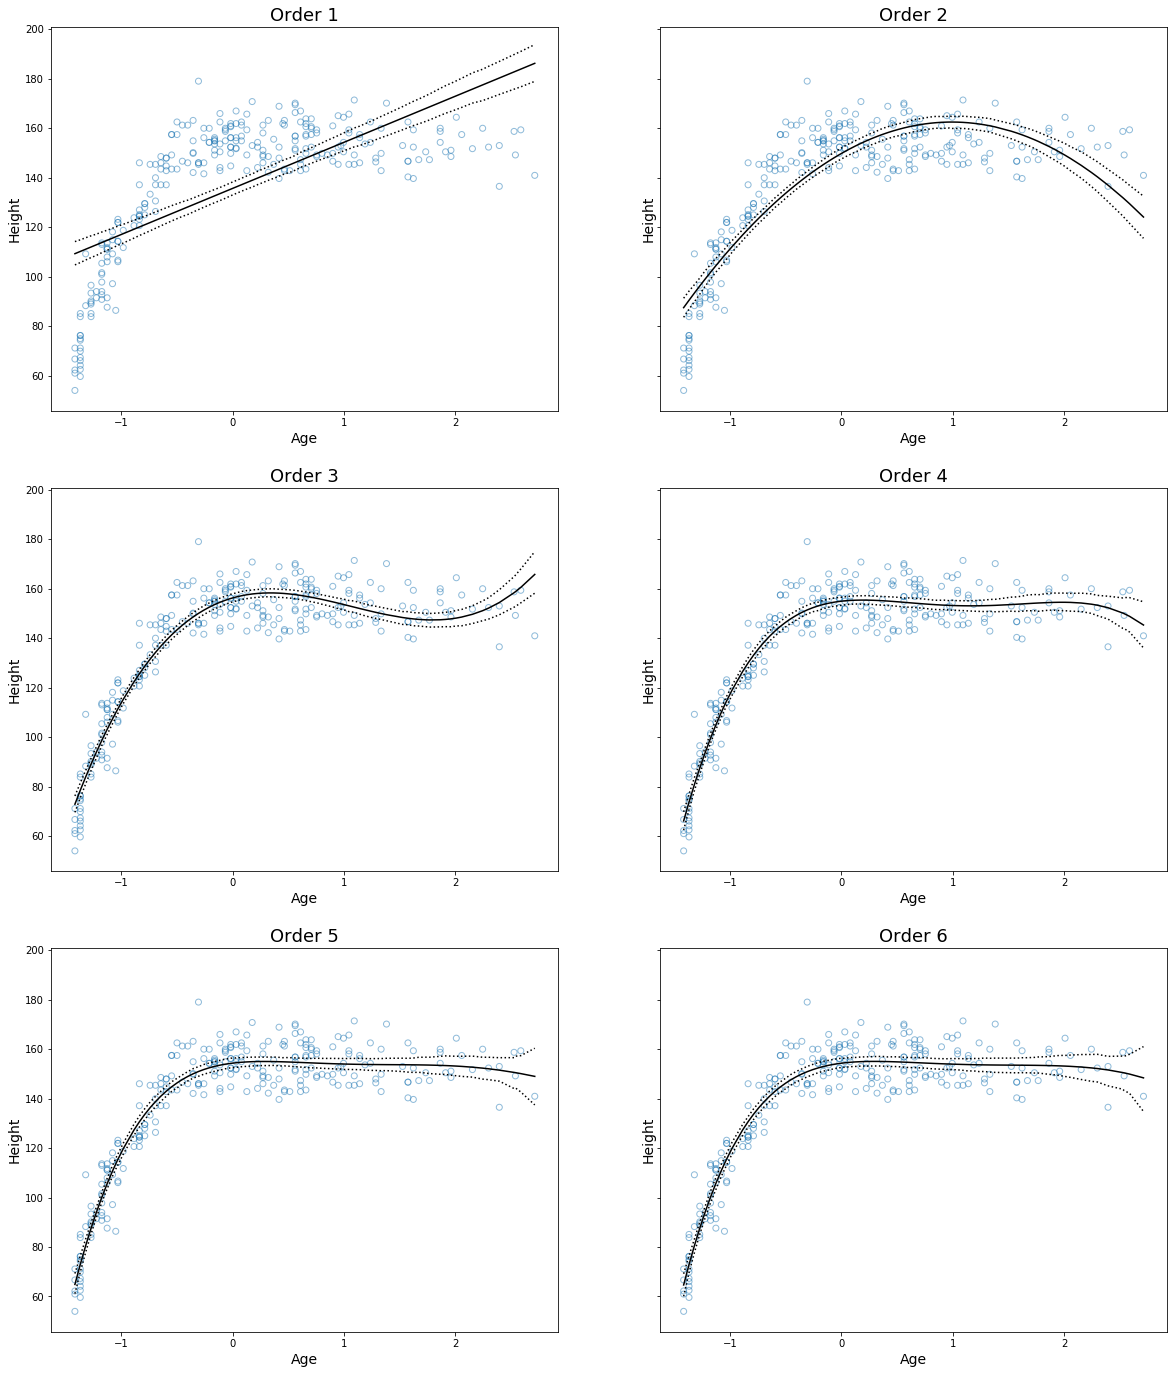

In [5]:
traces = [eval(f'trace_m6_{i}') for i in range(1,7)]

fig, axes = plt.subplots(3, 2, figsize=(20,24), sharey=True)

for i, (trace, ax) in enumerate(zip(traces, axes.ravel())):
    hpd = pm.stats.hpd(trace['mu'], credible_interval=0.97)
    
    ax.scatter(d1.age, d1.height, edgecolor='C0', facecolors='none', alpha=0.5)
    sns.lineplot(d1.age, trace['mu'].mean(0), ax=ax, ci=None, color='k')
    sns.lineplot(d1.age, hpd[:,0], ax=ax, ci=None, color='k')
    sns.lineplot(d1.age, hpd[:,1], ax=ax, ci=None, color='k')
    ax.lines[1].set_linestyle(":")
    ax.lines[2].set_linestyle(":")
    
    ax.set_xlabel('Age', fontsize=14)
    ax.set_ylabel('Height', fontsize=14)
    ax.set_title(f'Order {i+1}', fontsize=18)

###### 6H3
Now also plot the model averaged predictions, across all models. In what ways do the averaged predictions differ from the predictions of the model with the lowest WAIC value?

In [6]:
traces = [eval(f'trace_m6_{i}') for i in range(1,7)]
models = [eval(f'm6_{i}') for i in range(1,7)]

lowest_waic = pm.sample_posterior_predictive(trace_m6_4, 1000, m6_4, var_names=['h'])
lowest_waic_hpd = pm.stats.hpd(lowest_waic['h'], credible_interval=0.97)

ensemble = pm.sample_posterior_predictive_w(traces, 1000, models, weights=compare_df.weight.sort_index(ascending=True))
ensemble_hpd = pm.stats.hpd(ensemble['h'], credible_interval=0.97)

p_df = pd.DataFrame({
    'Age': d1.age, 
    'Height': d1.height,
    'Ensemble_Prediction': ensemble['h'].mean(0),
    'e1': ensemble_hpd[:,0],
    'e2': ensemble_hpd[:,1],
    'Best_Prediction': lowest_waic['h'].mean(0),
    'b1': lowest_waic_hpd[:,0],
    'b2': lowest_waic_hpd[:,1],
}).sort_values(by='Age')

100%|██████████| 1000/1000 [00:01<00:00, 865.09it/s]


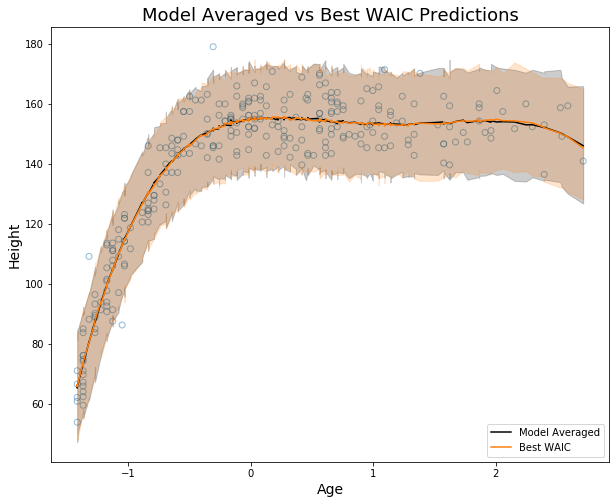

In [7]:
plt.figure(figsize=(10, 8))

plt.scatter(p_df.Age, p_df.Height, edgecolor='C0', facecolors='none', alpha=0.5)
    
plt.plot(p_df.Age, p_df.Ensemble_Prediction, color='k', label='Model Averaged')
plt.plot(p_df.Age, p_df.Best_Prediction, color='C1', label='Best WAIC')
plt.fill_between(p_df.Age, p_df.e1, p_df.e2, color='k', alpha=0.2)
plt.fill_between(p_df.Age, p_df.b1, p_df.b2, color='C1', alpha=0.2)


plt.xlabel('Age', fontsize=14)
plt.ylabel('Height', fontsize=14)
plt.title('Model Averaged vs Best WAIC Predictions', fontsize=18)
plt.legend(loc='lower right');

###### 6H4
Compute the test-sample deviance for each model. This means calculating the deviance, but using the data in d2 now. You can compute the log-likelihood of the height data with:

`sum( dnorm( d2$height, mu, sigma, log=TRUE ) )`  

where `mu` is a vector of predicted means (based upon age values and MAP parameters) and `sigma` is the MAP standard deviation.

In [8]:
test_deviances = {}
for i, trace in enumerate(traces):
    theta = pm.stats.summary(trace, varnames=['~mu'])['mean']
    mu = theta[0]
    for j in range(i+1):
        mu += theta[j+1] * d2.age.pow(j+1)
    d = stats.norm.logpdf(d2.height, loc=mu, scale=theta[-1])
    test_deviances[f'm{i+1}'] = -2 *np.sum(d)

test_deviances = pd.Series(test_deviances, name='test_deviance')
test_deviances

m1    2415.463296
m2    2156.117354
m3    1941.613874
m4    1907.023400
m5    1906.151069
m6    1907.131594
Name: test_deviance, dtype: float64

###### 6H5
Compare deviances from 6H4 to the WAIC values. It might be easier to compare if you subtract the smallest value in each list from the others. For example, subtract the minimum WAIC from all of the WAIC values so that the best WAIC is normalized to zero. Which model makes the best out of sample predictions in this case? Does WAIC do a good job of estimating the test deviance?

In [9]:
df = pd.concat([test_deviances, compare_df.waic], axis=1)
df = df.apply(lambda x: x - x.min(), axis=0)
df['difference'] = df.iloc[:,1] - df.iloc[:,0] 
df

,test_deviance,waic,difference
m1,509.312227,503.342,-5.97045
m2,249.966285,241.255,-8.71156
m3,35.462806,47.8241,12.3613
m4,0.872332,0,-0.872332
m5,0.000000,3.18676,3.18676
m6,0.980526,5.0518,4.07128


###### 6H6
Consider the following model:  
$$
\begin{align}
h_i &\sim \text{Normal($\mu_i, \sigma$)} \\
\mu_i &= \alpha + \beta_1x_i + \beta_2x_i^2 + \beta_3x_i^3 + \beta_4x_i^4 + \beta_5x_i^5 + \beta_6x_i^6 \\
\beta_1 &\sim \text{Normal(0, 5)} \\
\beta_2 &\sim \text{Normal(0, 5)} \\
\beta_3 &\sim \text{Normal(0, 5)} \\
\beta_4 &\sim \text{Normal(0, 5)} \\
\beta_5 &\sim \text{Normal(0, 5)} \\
\beta_6 &\sim \text{Normal(0, 5)} \\
\end{align}
$$  

and assume flat (or nearly flat) priors on $\alpha$ and $\sigma$. This model contains more strongly regularizing priors on the coefficients.

First, fit this model to the data in `d1`. Report the MAP estimates and plot the implied predictions. Then compute the out-of-sample deviance using data in `d2`, using MAP estimates from the model to fit to `d1` only. How does this model, using regularizing priors, compare to the best WAIC model from earlier? How do you interpret this result?

In [10]:
# fit this model to the data in d
with pm.Model() as m6_7:
    a = pm.Normal('a', mu=a_mean, sd=10)
    b = pm.Normal('b', mu=0, sd=5, shape=6)
    sigma = pm.Uniform('sd', 0, 50)
    mu = pm.Deterministic('mu', a + b[0] * d1["age"] + b[1] * d1["age"].pow(2) + b[2] * d1["age"].pow(3) + b[3] * d1["age"].pow(4) + b[4] * d1["age"].pow(5) + b[5] * d1["age"].pow(6))
    h = pm.Normal('h', mu=mu, sd=sigma, observed=d1["height"])
    trace_m6_7 = pm.sample(1000, tune=1000)
    pred_m6_7 = pm.sample_posterior_predictive(trace_m6_7, 1000)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, b, a]
100%|██████████| 1000/1000 [00:01<00:00, 868.38it/s]


In [11]:
# Report the MAP estimates
summary = pm.summary(trace_m6_7, var_names=['~mu'], kind='stats')
summary

,mean,sd,hpd_3%,hpd_97%
a,153.913,0.860,152.217,155.413
b[0],6.314,1.756,2.997,9.475
b[1],-12.632,2.108,-16.642,-8.995
b[2],9.857,2.668,4.711,14.589
b[3],-4.563,1.044,-6.503,-2.655
b[4],1.421,1.022,-0.522,3.264
b[5],-0.221,0.301,-0.784,0.337
sd,8.061,0.332,7.436,8.652


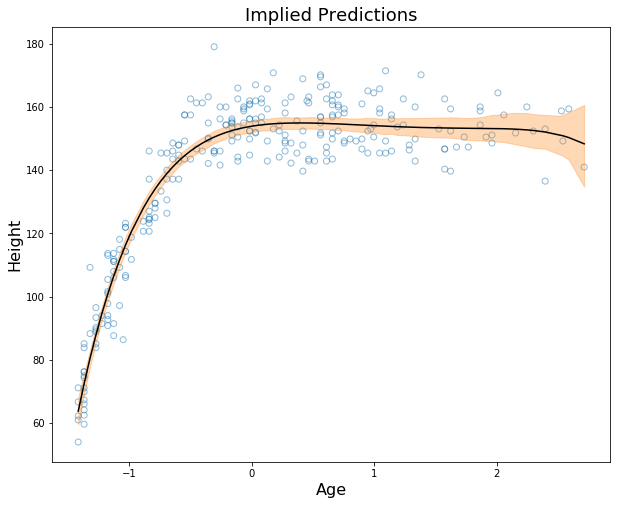

In [12]:
# plot the implied predictions
plt.figure(figsize=(10, 8))

df = pd.DataFrame({
    'age': d1.age,
    'height': d1.height,
    'mu_reg': trace_m6_7['mu'].mean(0),
    'm0': pm.stats.hpd(trace_m6_7['mu'], credible_interval=0.97)[:,0],
    'm1': pm.stats.hpd(trace_m6_7['mu'], credible_interval=0.97)[:,1],
    
}).sort_values(by='age')
plt.scatter(df.age, df.height, edgecolor='C0', facecolors='none', alpha=0.5)
plt.plot(df.age, df.mu_reg, 'k')
plt.fill_between(df.age, df.m0, df.m1, color='C1', alpha=0.3)
plt.title('Implied Predictions', fontsize=18)
plt.xlabel('Age', fontsize=16)
plt.ylabel('Height', fontsize=16);

In [13]:
# compute the out-of-sample deviance using data in d2
theta = summary['mean']
mu = theta[0]
for i, b in enumerate(theta[1:-1]):
    mu += b * d2.age.pow(i+1)
ll = stats.norm.logpdf(d2.height, loc=mu, scale=theta[-1])
dev = -2 * np.sum(ll)
print(f'Out-of-Sample Deviance: {dev}')

Out-of-Sample Deviance: 1912.781182674939


In [14]:
# Compare to model with best WAIC
print(f'Out-of-Sample Deviance: {dev}')
print(f'WAIC for best model: {compare_df.waic[0]}')
print(f'Difference: {dev - compare_df.waic[0]}')

Out-of-Sample Deviance: 1912.781182674939
WAIC for best model: 1906.7312899156173
Difference: 6.049892759321665


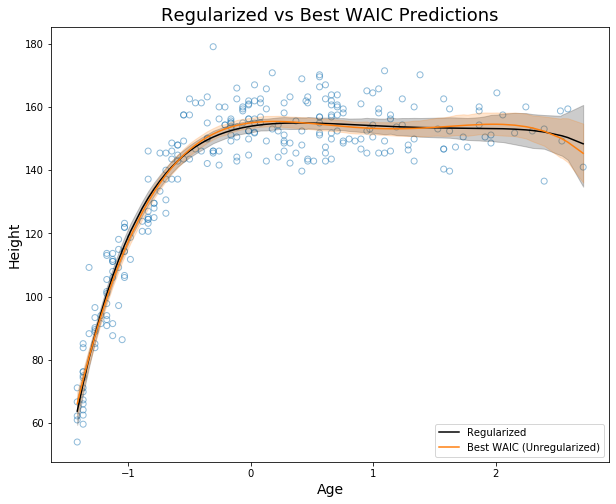

In [15]:
df = pd.DataFrame({
    'age': d1.age,
    'height': d1.height,
    'mu_reg': trace_m6_7['mu'].mean(0),
    'm0': pm.stats.hpd(trace_m6_7['mu'], credible_interval=0.97)[:,0],
    'm1': pm.stats.hpd(trace_m6_7['mu'], credible_interval=0.97)[:,1],
    'mu_nonreg': trace_m6_4['mu'].mean(0),
    'b0': pm.stats.hpd(trace_m6_4['mu'], credible_interval=0.97)[:,0],
    'b1': pm.stats.hpd(trace_m6_4['mu'], credible_interval=0.97)[:,1],
}).sort_values(by='age')

plt.figure(figsize=(10, 8))

plt.scatter(df.age, df.height, edgecolor='C0', facecolors='none', alpha=0.5)
    
plt.plot(df.age, df.mu_reg, color='k', label='Regularized')
plt.plot(df.age, df.mu_nonreg, color='C1', label='Best WAIC (Unregularized)')
plt.fill_between(df.age, df.m0, df.m1, color='k', alpha=0.2)
plt.fill_between(df.age, df.b0, df.b1, color='C1', alpha=0.2)

plt.xlabel('Age', fontsize=14)
plt.ylabel('Height', fontsize=14)
plt.title('Regularized vs Best WAIC Predictions', fontsize=18)
plt.legend(loc='lower right');